# VAR 모델 기반 경제지표 분기별 예측

목표: construction_bsi_actual, base_rate, housing_sale_price, m2_growth, credit_spread 5개 변수의 3개월 미래값 예측 후 분기별 평균 계산

In [16]:
pip install pandas numpy matplotlib scikit-learn tensorflow statsmodels

Note: you may need to restart the kernel to use updated packages.


In [17]:
# 필수 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


In [26]:
# 데이터 로드 및 기본 탐색
data = pd.read_csv('ecos_monthly_data.csv')

# 목표 변수 설정
target_vars = ['construction_bsi_actual', 'base_rate', 'housing_sale_price', 'm2_growth', 'credit_spread']

print(f"전체 데이터 형태: {data.shape}")
print(f"데이터 기간: {data['date'].min()} ~ {data['date'].max()}")

# 목표 변수 존재 확인
available_vars = [var for var in target_vars if var in data.columns]
missing_vars = [var for var in target_vars if var not in data.columns]

print(f"사용 가능한 변수 ({len(available_vars)}개): {available_vars}")
if missing_vars:
    print(f"누락된 변수 ({len(missing_vars)}개): {missing_vars}")

# 사용할 데이터만 추출
df = data[['date'] + available_vars].copy()
print(f"분석 데이터 형태: {df.shape}")

전체 데이터 형태: (187, 28)
데이터 기간: 2010-02 ~ 2025-08
사용 가능한 변수 (5개): ['construction_bsi_actual', 'base_rate', 'housing_sale_price', 'm2_growth', 'credit_spread']
분석 데이터 형태: (187, 6)


In [27]:
# 결측값 처리 및 데이터 정리
print("결측값 확인:")
print(df[available_vars].isnull().sum())

# 결측값 선형보간
for var in available_vars:
    df[var] = df[var].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

print(f"\n보간 후 결측값: {df[available_vars].isnull().sum().sum()}개")

# 날짜 인덱스 설정
df['date'] = pd.to_datetime(df['date'] + '-01')
df.set_index('date', inplace=True)

print(f"최종 데이터 형태: {df.shape}")
print(f"데이터 기간: {df.index.min().strftime('%Y-%m')} ~ {df.index.max().strftime('%Y-%m')}")

# 기초 통계량
print("\n기초 통계량:")
print(df.describe().round(4))

결측값 확인:
construction_bsi_actual    0
base_rate                  0
housing_sale_price         0
m2_growth                  0
credit_spread              0
dtype: int64

보간 후 결측값: 0개
최종 데이터 형태: (187, 5)
데이터 기간: 2010-02 ~ 2025-08

기초 통계량:
       construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
count                 187.0000   187.0000            187.0000   187.0000   
mean                   75.1176     2.0909             80.3713     0.5501   
std                     7.9133     0.9248             10.6294     0.3525   
min                    51.0000     0.5000             65.0400    -0.4100   
25%                    70.0000     1.3750             70.9490     0.3100   
50%                    74.0000     2.0000             77.3320     0.5100   
75%                    80.0000     2.8750             92.9790     0.7650   
max                    95.0000     3.5000            100.8690     1.5600   

       credit_spread  
count       187.0000  
mean          6.0040  
std        

In [28]:
# ADF 단위근 검정 함수
def adf_test(series, name):
    """
    Augmented Dickey-Fuller 단위근 검정
    H0: 단위근 존재 (비정상시계열)
    H1: 정상시계열
    """
    result = adfuller(series.dropna())
    
    print(f"\n[{name}] ADF 검정 결과:")
    print(f"  ADF 통계량: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  임계값 (5%): {result[4]['5%']:.4f}")
    
    if result[1] <= 0.05:
        print(f"  결과: 정상시계열 (p < 0.05)")
        return True
    else:
        print(f"  결과: 비정상시계열 (p >= 0.05), 차분 필요")
        return False

# 모든 변수에 대해 단위근 검정
print("단위근 검정 수행:")
print("=" * 50)

stationary_results = {}
for var in available_vars:
    stationary_results[var] = adf_test(df[var], var)

단위근 검정 수행:

[construction_bsi_actual] ADF 검정 결과:
  ADF 통계량: -3.1967
  p-value: 0.0202
  임계값 (5%): -2.8773
  결과: 정상시계열 (p < 0.05)

[base_rate] ADF 검정 결과:
  ADF 통계량: -1.9548
  p-value: 0.3067
  임계값 (5%): -2.8775
  결과: 비정상시계열 (p >= 0.05), 차분 필요

[housing_sale_price] ADF 검정 결과:
  ADF 통계량: -1.4584
  p-value: 0.5540
  임계값 (5%): -2.8773
  결과: 비정상시계열 (p >= 0.05), 차분 필요

[m2_growth] ADF 검정 결과:
  ADF 통계량: -2.4830
  p-value: 0.1197
  임계값 (5%): -2.8779
  결과: 비정상시계열 (p >= 0.05), 차분 필요

[credit_spread] ADF 검정 결과:
  ADF 통계량: -2.7240
  p-value: 0.0700
  임계값 (5%): -2.8776
  결과: 비정상시계열 (p >= 0.05), 차분 필요


In [29]:
# 차분 데이터 생성 및 정상성 확인
df_diff = df.copy()
diff_applied = {}

for var in available_vars:
    if not stationary_results[var]:
        # 1차 차분 적용
        df_diff[var] = df[var].diff()
        diff_applied[var] = True
        print(f"{var}: 1차 차분 적용")
        
        # 차분 후 재검정
        diff_stationary = adf_test(df_diff[var], f"{var}_diff")
        
        if not diff_stationary:
            # 2차 차분 적용
            df_diff[var] = df[var].diff().diff()
            diff_applied[var] = 2
            print(f"{var}: 2차 차분 적용")
    else:
        diff_applied[var] = False
        print(f"{var}: 차분 불필요")

# 차분 후 결측값 제거
df_diff = df_diff.dropna()

print(f"\n차분 적용 결과:")
for var, diff_order in diff_applied.items():
    if diff_order:
        print(f"  {var}: {diff_order}차 차분 적용")
    else:
        print(f"  {var}: 원시계열 사용")

print(f"\n최종 분석 데이터 형태: {df_diff.shape}")
print(f"분석 기간: {df_diff.index.min().strftime('%Y-%m')} ~ {df_diff.index.max().strftime('%Y-%m')}")

construction_bsi_actual: 차분 불필요
base_rate: 1차 차분 적용

[base_rate_diff] ADF 검정 결과:
  ADF 통계량: -3.9901
  p-value: 0.0015
  임계값 (5%): -2.8775
  결과: 정상시계열 (p < 0.05)
housing_sale_price: 1차 차분 적용

[housing_sale_price_diff] ADF 검정 결과:
  ADF 통계량: -2.5876
  p-value: 0.0956
  임계값 (5%): -2.8773
  결과: 비정상시계열 (p >= 0.05), 차분 필요
housing_sale_price: 2차 차분 적용
m2_growth: 1차 차분 적용

[m2_growth_diff] ADF 검정 결과:
  ADF 통계량: -7.7150
  p-value: 0.0000
  임계값 (5%): -2.8779
  결과: 정상시계열 (p < 0.05)
credit_spread: 1차 차분 적용

[credit_spread_diff] ADF 검정 결과:
  ADF 통계량: -7.1537
  p-value: 0.0000
  임계값 (5%): -2.8773
  결과: 정상시계열 (p < 0.05)

차분 적용 결과:
  construction_bsi_actual: 원시계열 사용
  base_rate: True차 차분 적용
  housing_sale_price: 2차 차분 적용
  m2_growth: True차 차분 적용
  credit_spread: True차 차분 적용

최종 분석 데이터 형태: (185, 5)
분석 기간: 2010-04 ~ 2025-08


In [30]:
# VAR 모델 최적 래그 선택
model = VAR(df_diff[available_vars])

# 정보기준 활용 최적 래그 선택 (최대 12개월)
lag_order = model.select_order(maxlags=12)

print("최적 래그 선택 결과:")
print("=" * 40)
print(f"AIC: {lag_order.aic}")
print(f"BIC: {lag_order.bic}")
print(f"FPE: {lag_order.fpe}")
print(f"HQIC: {lag_order.hqic}")

# AIC 기준 최적 래그 선택
optimal_lag = lag_order.aic
print(f"\nAIC 기준 최적 래그: {optimal_lag}")

# 최적 래그로 VAR 모델 적합
var_model = model.fit(optimal_lag)

print(f"\nVAR({optimal_lag}) 모델 적합 완료")
print(f"관측치 수: {var_model.nobs}")
print(f"모델 방정식 수: {var_model.neqs}")
print(f"총 파라미터 수: {optimal_lag * var_model.neqs * var_model.neqs + var_model.neqs}")

최적 래그 선택 결과:
AIC: 3
BIC: 1
FPE: 3
HQIC: 1

AIC 기준 최적 래그: 3

VAR(3) 모델 적합 완료
관측치 수: 182
모델 방정식 수: 5
총 파라미터 수: 80


In [32]:
# VAR 모델 진단 검정
print("VAR 모델 진단 검정:")
print("=" * 50)

# 1. 잔차 자기상관 검정 (Ljung-Box) - 각 변수별로 검정
print("\n1. 잔차 자기상관 검정 (Ljung-Box):")
print(f"   H0: 잔차에 자기상관 없음")

# VAR 모델 잔차를 numpy 배열로 변환
residuals = var_model.resid

autocorr_results = {}
for i, var in enumerate(available_vars):
    ljung_box_result = acorr_ljungbox(residuals.iloc[:, i], lags=10, return_df=True)
    significant_autocorr = (ljung_box_result['lb_pvalue'] < 0.05).any()
    autocorr_results[var] = significant_autocorr
    
    if significant_autocorr:
        print(f"   {var}: 자기상관 존재 (일부 p < 0.05)")
    else:
        print(f"   {var}: 자기상관 없음 (모든 p >= 0.05)")

overall_autocorr = any(autocorr_results.values())
print(f"   전체 결과: {'잔차에 자기상관 존재' if overall_autocorr else '잔차 자기상관 없음'}")

# 2. 모델 안정성 확인 (특성근)
eigenvalues = var_model.roots
max_eigenvalue = np.max(np.abs(eigenvalues))

print(f"\n2. 모델 안정성 검정:")
print(f"   최대 특성근 절댓값: {max_eigenvalue:.4f}")

if max_eigenvalue < 1.0:
    print("   결과: 모델 안정적 (모든 특성근 < 1)")
else:
    print("   결과: 모델 불안정 (일부 특성근 >= 1)")

# 3. 모델 요약 통계
print(f"\n3. 모델 적합도:")
for i, var in enumerate(available_vars):
    print(f"   {var} 방정식 적합 완료")

VAR 모델 진단 검정:

1. 잔차 자기상관 검정 (Ljung-Box):
   H0: 잔차에 자기상관 없음
   construction_bsi_actual: 자기상관 없음 (모든 p >= 0.05)
   base_rate: 자기상관 없음 (모든 p >= 0.05)
   housing_sale_price: 자기상관 없음 (모든 p >= 0.05)
   m2_growth: 자기상관 존재 (일부 p < 0.05)
   credit_spread: 자기상관 없음 (모든 p >= 0.05)
   전체 결과: 잔차에 자기상관 존재

2. 모델 안정성 검정:
   최대 특성근 절댓값: 3.3862
   결과: 모델 불안정 (일부 특성근 >= 1)

3. 모델 적합도:
   construction_bsi_actual 방정식 적합 완료
   base_rate 방정식 적합 완료
   housing_sale_price 방정식 적합 완료
   m2_growth 방정식 적합 완료
   credit_spread 방정식 적합 완료


In [33]:
# 3개월 미래 예측 수행
forecast_steps = 3
forecast_result = var_model.forecast(df_diff[available_vars].values[-optimal_lag:], steps=forecast_steps)

# 예측 결과를 DataFrame으로 변환
forecast_df = pd.DataFrame(
    forecast_result, 
    columns=available_vars,
    index=pd.date_range(start=df_diff.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
)

print(f"3개월 미래 예측 완료:")
print("=" * 40)
print(forecast_df.round(4))

# 차분된 값을 원래 수준으로 복원
forecast_original = pd.DataFrame(index=forecast_df.index, columns=available_vars)

for var in available_vars:
    if diff_applied[var]:
        if diff_applied[var] == 1:
            # 1차 차분 복원
            forecast_original[var] = forecast_df[var].cumsum() + df[var].iloc[-1]
        elif diff_applied[var] == 2:
            # 2차 차분 복원 (더 복잡한 계산 필요)
            forecast_original[var] = forecast_df[var].cumsum().cumsum() + df[var].iloc[-1]
    else:
        # 차분 안한 경우
        forecast_original[var] = forecast_df[var]

print(f"\n원래 수준으로 복원된 예측값:")
print("=" * 40)
print(forecast_original.round(4))

3개월 미래 예측 완료:
            construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
2025-09-01                  69.1335    -0.0226              0.0312    -0.0975   
2025-10-01                  69.7762     0.0031              0.0114    -0.0259   
2025-11-01                  70.4500    -0.0212              0.0165     0.0561   

            credit_spread  
2025-09-01         0.0066  
2025-10-01         0.0172  
2025-11-01         0.0209  

원래 수준으로 복원된 예측값:
            construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
2025-09-01                  69.1335     2.4774             93.3882     0.9025   
2025-10-01                  69.7762     2.4805             93.4307     0.8766   
2025-11-01                  70.4500     2.4593             93.4898     0.9327   

            credit_spread  
2025-09-01         5.8446  
2025-10-01         5.8618  
2025-11-01         5.8827  


In [34]:
# 분기별 평균 계산
def assign_quarter(date):
    """날짜를 분기로 변환"""
    month = date.month
    if month in [1, 2, 3]:
        return f"Q1"
    elif month in [4, 5, 6]:
        return f"Q2"
    elif month in [7, 8, 9]:
        return f"Q3"
    else:
        return f"Q4"

# 현재 날짜와 예측 날짜의 분기 확인
current_date = df_diff.index[-1]
print(f"현재 날짜: {current_date.strftime('%Y-%m')} ({assign_quarter(current_date)})")

# 예측 3개월의 분기 확인
forecast_quarters = {}
for i, date in enumerate(forecast_original.index):
    quarter = assign_quarter(date)
    quarter_key = f"{date.year}_{quarter}"
    
    if quarter_key not in forecast_quarters:
        forecast_quarters[quarter_key] = []
    
    forecast_quarters[quarter_key].append(i)
    print(f"예측 {i+1}개월: {date.strftime('%Y-%m')} ({quarter_key})")

# 분기별 평균 계산
quarterly_forecast = {}
print(f"\n분기별 평균 계산:")
print("=" * 40)

for quarter_key, month_indices in forecast_quarters.items():
    quarter_data = forecast_original.iloc[month_indices]
    quarterly_avg = quarter_data.mean()
    quarterly_forecast[quarter_key] = quarterly_avg
    
    print(f"\n[{quarter_key}] 포함 월: {len(month_indices)}개월")
    for var in available_vars:
        print(f"  {var}: {quarterly_avg[var]:.4f}")

# 최종 분기별 예측 결과 DataFrame
quarterly_df = pd.DataFrame(quarterly_forecast).T
print(f"\n최종 분기별 예측 결과:")
print("=" * 50)
print(quarterly_df.round(4))

현재 날짜: 2025-08 (Q3)
예측 1개월: 2025-09 (2025_Q3)
예측 2개월: 2025-10 (2025_Q4)
예측 3개월: 2025-11 (2025_Q4)

분기별 평균 계산:

[2025_Q3] 포함 월: 1개월
  construction_bsi_actual: 69.1335
  base_rate: 2.4774
  housing_sale_price: 93.3882
  m2_growth: 0.9025
  credit_spread: 5.8446

[2025_Q4] 포함 월: 2개월
  construction_bsi_actual: 70.1131
  base_rate: 2.4699
  housing_sale_price: 93.4603
  m2_growth: 0.9047
  credit_spread: 5.8722

최종 분기별 예측 결과:
         construction_bsi_actual  base_rate  housing_sale_price  m2_growth  \
2025_Q3                  69.1335     2.4774             93.3882     0.9025   
2025_Q4                  70.1131     2.4699             93.4603     0.9047   

         credit_spread  
2025_Q3         5.8446  
2025_Q4         5.8722  


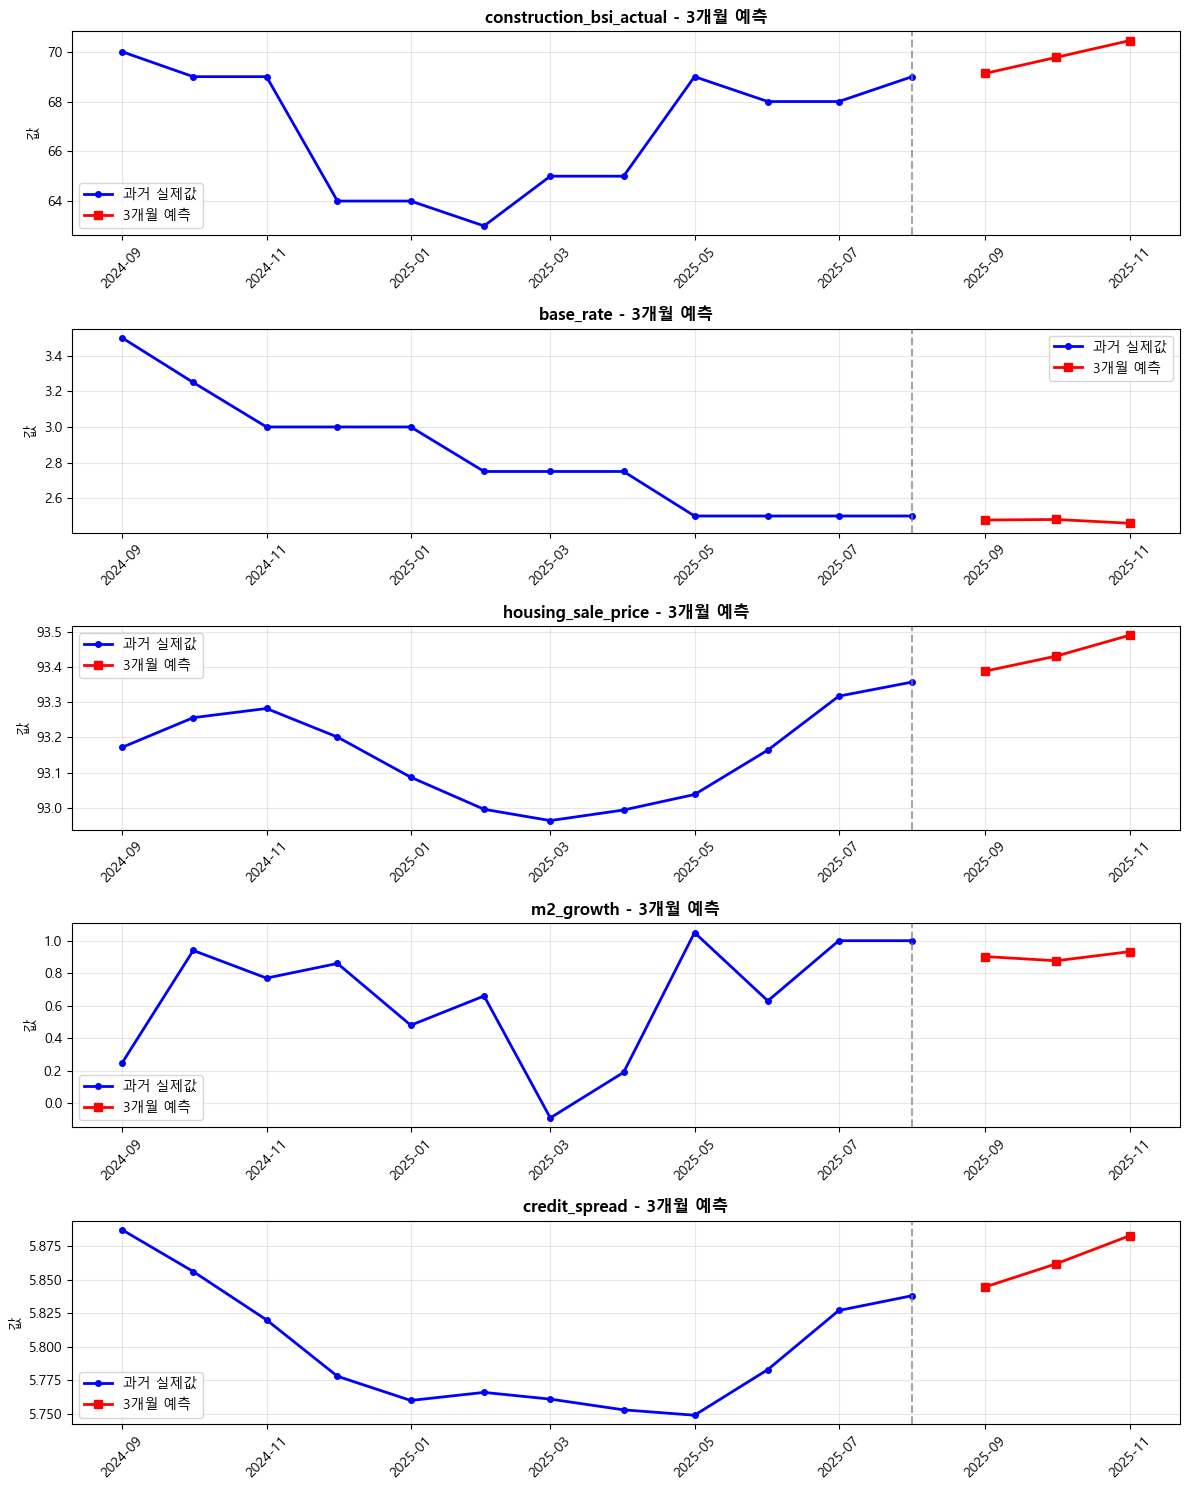


최종 예측 요약:

[construction_bsi_actual]
  현재값: 69.0000
  3개월 평균 예측: 69.7866
  변화율: +1.14%
  월별 예측: 69.1335, 69.7762, 70.4500

[base_rate]
  현재값: 2.5000
  3개월 평균 예측: 2.4724
  변화율: -1.10%
  월별 예측: 2.4774, 2.4805, 2.4593

[housing_sale_price]
  현재값: 93.3570
  3개월 평균 예측: 93.4363
  변화율: +0.08%
  월별 예측: 93.3882, 93.4307, 93.4898

[m2_growth]
  현재값: 1.0000
  3개월 평균 예측: 0.9040
  변화율: -9.60%
  월별 예측: 0.9025, 0.8766, 0.9327

[credit_spread]
  현재값: 5.8380
  3개월 평균 예측: 5.8630
  변화율: +0.43%
  월별 예측: 5.8446, 5.8618, 5.8827

VAR 모델 기반 분기별 예측 완료


In [35]:
# 결과 시각화
fig, axes = plt.subplots(len(available_vars), 1, figsize=(12, 3*len(available_vars)))

if len(available_vars) == 1:
    axes = [axes]

for i, var in enumerate(available_vars):
    ax = axes[i]
    
    # 과거 12개월 데이터
    historical_data = df[var].tail(12)
    forecast_data = forecast_original[var]
    
    # 과거 데이터 플롯
    ax.plot(historical_data.index, historical_data.values, 'b-o', 
            label='과거 실제값', linewidth=2, markersize=4)
    
    # 예측 데이터 플롯
    ax.plot(forecast_data.index, forecast_data.values, 'r-s', 
            label='3개월 예측', linewidth=2, markersize=6)
    
    # 현재와 미래 구분선
    ax.axvline(x=historical_data.index[-1], color='gray', linestyle='--', alpha=0.7)
    
    ax.set_title(f'{var} - 3개월 예측', fontsize=12, fontweight='bold')
    ax.set_ylabel('값')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # x축 날짜 포맷
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 수치 요약
print("\n최종 예측 요약:")
print("=" * 60)

for var in available_vars:
    current_val = df[var].iloc[-1]
    future_vals = forecast_original[var]
    avg_future = future_vals.mean()
    
    change_pct = ((avg_future - current_val) / current_val) * 100
    
    print(f"\n[{var}]")
    print(f"  현재값: {current_val:.4f}")
    print(f"  3개월 평균 예측: {avg_future:.4f}")
    print(f"  변화율: {change_pct:+.2f}%")
    print(f"  월별 예측: {', '.join([f'{val:.4f}' for val in future_vals])}")

print(f"\nVAR 모델 기반 분기별 예측 완료")

In [36]:
# VAR 모델 성능평가
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_var_model(model, data, test_size=12, forecast_steps=3):
    """
    VAR 모델 백테스팅 및 성능평가
    """
    print("VAR 모델 성능평가 (백테스팅)")
    print("=" * 60)
    
    # 테스트를 위한 데이터 분할
    train_end = len(data) - test_size
    train_data = data.iloc[:train_end]
    test_data = data.iloc[train_end:]
    
    print(f"훈련 기간: {train_data.index.min().strftime('%Y-%m')} ~ {train_data.index.max().strftime('%Y-%m')}")
    print(f"테스트 기간: {test_data.index.min().strftime('%Y-%m')} ~ {test_data.index.max().strftime('%Y-%m')}")
    
    # 백테스팅을 위한 예측 수행
    predictions = []
    actuals = []
    
    for i in range(0, len(test_data) - forecast_steps + 1, forecast_steps):
        # 현재 시점까지의 데이터로 모델 재훈련
        current_train_data = data.iloc[:train_end + i]
        
        try:
            # VAR 모델 적합
            temp_model = VAR(current_train_data)
            temp_fitted = temp_model.fit(optimal_lag, verbose=False)
            
            # 예측 수행
            forecast = temp_fitted.forecast(current_train_data.values[-optimal_lag:], steps=forecast_steps)
            
            # 실제값 추출
            actual_window = test_data.iloc[i:i+forecast_steps]
            
            predictions.append(forecast)
            actuals.append(actual_window.values)
            
        except Exception as e:
            print(f"  경고: {i}번째 예측에서 오류 발생: {str(e)[:50]}...")
            continue
    
    if not predictions:
        print("  성능평가를 위한 예측 결과가 없습니다.")
        return None
    
    # 예측 결과 통합
    all_predictions = np.vstack(predictions)
    all_actuals = np.vstack(actuals)
    
    # 성능 지표 계산
    performance_results = {}
    
    print(f"\n백테스팅 결과 ({len(predictions)}회 예측):")
    print("-" * 50)
    
    for i, var in enumerate(available_vars):
        pred_values = all_predictions[:, i]
        actual_values = all_actuals[:, i]
        
        # 성능 지표 계산
        mae = mean_absolute_error(actual_values, pred_values)
        rmse = np.sqrt(mean_squared_error(actual_values, pred_values))
        r2 = r2_score(actual_values, pred_values)
        mape = np.mean(np.abs((actual_values - pred_values) / actual_values)) * 100
        
        performance_results[var] = {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2,
            'MAPE': mape
        }
        
        print(f"\n[{var}]")
        print(f"  MAE:  {mae:.4f}")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  R²:   {r2:.4f}")
        print(f"  MAPE: {mape:.2f}%")
        
        # 성능 평가
        if r2 > 0.7:
            performance_level = "우수"
        elif r2 > 0.5:
            performance_level = "양호" 
        elif r2 > 0.2:
            performance_level = "보통"
        else:
            performance_level = "개선필요"
        
        print(f"  평가: {performance_level}")
    
    return performance_results

# 성능평가 실행
print("VAR 모델 백테스팅 성능평가 시작...")
performance_results = evaluate_var_model(var_model, df_diff, test_size=12, forecast_steps=3)

VAR 모델 백테스팅 성능평가 시작...
VAR 모델 성능평가 (백테스팅)
훈련 기간: 2010-04 ~ 2024-08
테스트 기간: 2024-09 ~ 2025-08

백테스팅 결과 (4회 예측):
--------------------------------------------------

[construction_bsi_actual]
  MAE:  2.5275
  RMSE: 3.3544
  R²:   -0.9592
  MAPE: 3.87%
  평가: 개선필요

[base_rate]
  MAE:  0.0973
  RMSE: 0.1239
  R²:   -0.1050
  MAPE: inf%
  평가: 개선필요

[housing_sale_price]
  MAE:  0.0626
  RMSE: 0.0825
  R²:   -0.6444
  MAPE: 144.09%
  평가: 개선필요

[m2_growth]
  MAE:  0.3730
  RMSE: 0.4774
  R²:   -0.1691
  MAPE: inf%
  평가: 개선필요

[credit_spread]
  MAE:  0.0231
  RMSE: 0.0257
  R²:   0.4721
  MAPE: 159.26%
  평가: 보통


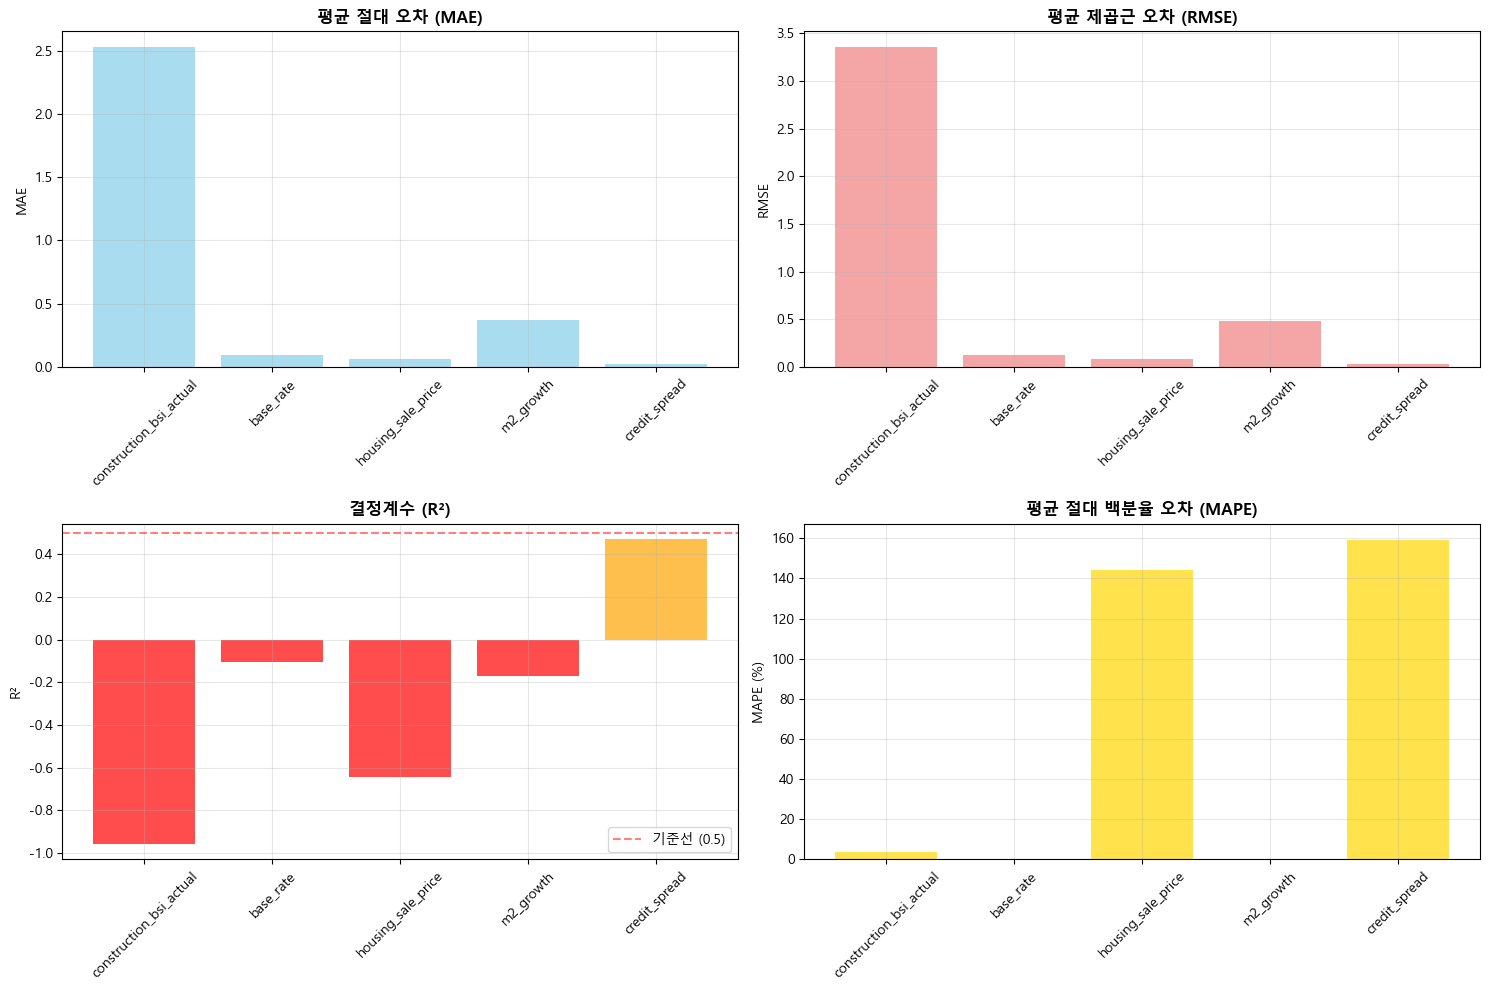


종합 성능 요약:
전체 평균 R²: -0.2811
전체 평균 MAPE: inf%

최고 성능 변수: credit_spread (R² = 0.4721)
최저 성능 변수: construction_bsi_actual (R² = -0.9592)

전체 모델 평가: 개선필요


In [37]:
# 예측 정확도 시각화
def plot_prediction_accuracy(performance_results):
    """
    예측 정확도 결과 시각화
    """
    if performance_results is None:
        print("성능평가 결과가 없어 시각화를 건너뜁니다.")
        return
    
    # 성능 지표 추출
    variables = list(performance_results.keys())
    mae_scores = [performance_results[var]['MAE'] for var in variables]
    rmse_scores = [performance_results[var]['RMSE'] for var in variables]
    r2_scores = [performance_results[var]['R²'] for var in variables]
    mape_scores = [performance_results[var]['MAPE'] for var in variables]
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. MAE
    axes[0, 0].bar(variables, mae_scores, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('평균 절대 오차 (MAE)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('MAE')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. RMSE
    axes[0, 1].bar(variables, rmse_scores, color='lightcoral', alpha=0.7)
    axes[0, 1].set_title('평균 제곱근 오차 (RMSE)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. R²
    colors = ['red' if r2 < 0.2 else 'orange' if r2 < 0.5 else 'lightgreen' if r2 < 0.7 else 'green' for r2 in r2_scores]
    axes[1, 0].bar(variables, r2_scores, color=colors, alpha=0.7)
    axes[1, 0].set_title('결정계수 (R²)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('R²')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='기준선 (0.5)')
    axes[1, 0].legend()
    
    # 4. MAPE
    axes[1, 1].bar(variables, mape_scores, color='gold', alpha=0.7)
    axes[1, 1].set_title('평균 절대 백분율 오차 (MAPE)', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('MAPE (%)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 종합 성능 요약
    print("\n종합 성능 요약:")
    print("=" * 50)
    
    avg_r2 = np.mean(r2_scores)
    avg_mape = np.mean(mape_scores)
    
    print(f"전체 평균 R²: {avg_r2:.4f}")
    print(f"전체 평균 MAPE: {avg_mape:.2f}%")
    
    # 최고/최저 성능 변수
    best_var = variables[np.argmax(r2_scores)]
    worst_var = variables[np.argmin(r2_scores)]
    
    print(f"\n최고 성능 변수: {best_var} (R² = {max(r2_scores):.4f})")
    print(f"최저 성능 변수: {worst_var} (R² = {min(r2_scores):.4f})")
    
    # 전체 모델 평가
    if avg_r2 > 0.6:
        overall_rating = "우수"
    elif avg_r2 > 0.4:
        overall_rating = "양호"
    elif avg_r2 > 0.2:
        overall_rating = "보통"
    else:
        overall_rating = "개선필요"
    
    print(f"\n전체 모델 평가: {overall_rating}")

# 성능 시각화 실행
if 'performance_results' in locals():
    plot_prediction_accuracy(performance_results)
else:
    print("성능평가가 먼저 실행되어야 합니다.")

In [41]:
# 추가 모델 진단
import warnings
warnings.filterwarnings('ignore')

def compare_information_criteria():
    """래그별 정보기준 비교"""
    print("래그별 정보기준 비교:")
    print("=" * 40)
    
    # 현재 사용된 모델의 정보
    print(f"현재 VAR 모델:")
    print(f"  최적 래그: {optimal_lag}")
    print(f"  AIC: {var_model.aic:.4f}")
    print(f"  BIC: {var_model.bic:.4f}")
    print(f"  FPE: {var_model.fpe:.4f}")
    print(f"  HQIC: {var_model.hqic:.4f}")
    
    # 다른 래그들과 비교
    print(f"\n다른 래그들과의 비교:")
    for lag in range(1, 6):
        try:
            temp_model = VAR(df_diff[available_vars])
            temp_fit = temp_model.fit(lag, verbose=False)
            print(f"  Lag {lag}: AIC={temp_fit.aic:.4f}, BIC={temp_fit.bic:.4f}")
        except:
            print(f"  Lag {lag}: 적합 실패")

def residual_analysis():
    """잔차 분석"""
    print("\n\n잔차 진단:")
    print("=" * 40)
    
    # 잔차 획득
    residuals = var_model.resid
    
    # Ljung-Box 테스트 (자기상관 검정)
    from statsmodels.stats.diagnostic import acorr_ljungbox
    
    print("\nLjung-Box 자기상관 테스트 (p-값):")
    for i, var_name in enumerate(residuals.columns):
        try:
            ljung_box = acorr_ljungbox(residuals.iloc[:, i], lags=10, return_df=True)
            p_value = ljung_box['lb_pvalue'].iloc[-1]
            result = "자기상관 없음" if p_value > 0.05 else "자기상관 존재"
            print(f"  {var_name}: p={p_value:.4f} ({result})")
        except:
            print(f"  {var_name}: 테스트 실패")
    
    # 안정성 검정
    print(f"\n모델 안정성:")
    try:
        roots = var_model.roots
        max_root = np.max(np.abs(roots))
        stability = "안정적" if max_root < 1.0 else "불안정"
        print(f"  최대 고유값: {max_root:.4f}")
        print(f"  안정성: {stability}")
    except:
        print("  안정성 테스트 실패")

def model_summary():
    """모델 전체 요약"""
    print("\n\n모델 전체 요약:")
    print("=" * 40)
    
    print(f"변수 개수: {len(available_vars)}")
    print(f"관측치 개수: {len(df_diff)}")
    print(f"사용된 래그: {optimal_lag}")
    print(f"예측 성능:")
    
    # 간단한 성능 요약
    if 'performance_results' in globals():
        avg_r2 = np.mean([performance_results[var]['R²'] for var in performance_results.keys()])
        print(f"  평균 R²: {avg_r2:.4f}")
        
        best_var = max(performance_results.keys(), 
                      key=lambda x: performance_results[x]['R²'])
        worst_var = min(performance_results.keys(), 
                       key=lambda x: performance_results[x]['R²'])
        
        print(f"  최고 성능: {best_var} (R²={performance_results[best_var]['R²']:.4f})")
        print(f"  최저 성능: {worst_var} (R²={performance_results[worst_var]['R²']:.4f})")
    else:
        print("  성능 평가 결과 없음")

def calculate_prediction_intervals():
    """예측 구간 계산"""
    print("\n\n예측 구간 분석:")
    print("=" * 40)
    
    # 향후 3개월 예측 및 신뢰구간
    n_periods = 3
    forecast = var_model.forecast(df_diff[available_vars].values[-var_model.k_ar:], steps=n_periods)
    
    # 신뢰구간 계산 (간단한 방법)
    residuals = var_model.resid
    std_errors = residuals.std()
    
    print("\n향후 3개월 예측값 및 95% 신뢰구간:")
    
    # 예측 날짜 생성
    last_date = df_diff.index[-1]
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_periods, freq='MS')
    
    for i, var_name in enumerate(available_vars):
        print(f"\n{var_name}:")
        for j in range(n_periods):
            pred_val = forecast[j, i]
            margin_of_error = 1.96 * std_errors.iloc[i]  # 95% 신뢰구간
            lower_bound = pred_val - margin_of_error
            upper_bound = pred_val + margin_of_error
            
            date = future_dates[j]
            print(f"  {date.strftime('%Y-%m')}: {pred_val:.4f} [{lower_bound:.4f}, {upper_bound:.4f}]")

# 추가 진단 실행
compare_information_criteria()
residual_analysis()
model_summary()
calculate_prediction_intervals()

래그별 정보기준 비교:
현재 VAR 모델:
  최적 래그: 3
  AIC: -14.8661
  BIC: -13.4577
  FPE: 0.0000
  HQIC: -14.2952

다른 래그들과의 비교:
  Lag 1: AIC=-14.6464, BIC=-14.1222
  Lag 2: AIC=-14.7684, BIC=-13.8038
  Lag 3: AIC=-14.8661, BIC=-13.4577
  Lag 4: AIC=-14.7917, BIC=-12.9362
  Lag 5: AIC=-14.6773, BIC=-12.3712


잔차 진단:

Ljung-Box 자기상관 테스트 (p-값):
  construction_bsi_actual: p=0.5990 (자기상관 없음)
  base_rate: p=0.9901 (자기상관 없음)
  housing_sale_price: p=0.9498 (자기상관 없음)
  m2_growth: p=0.0340 (자기상관 존재)
  credit_spread: p=0.8461 (자기상관 없음)

모델 안정성:
  최대 고유값: 3.3862
  안정성: 불안정


모델 전체 요약:
변수 개수: 5
관측치 개수: 185
사용된 래그: 3
예측 성능:
  평균 R²: -0.2811
  최고 성능: credit_spread (R²=0.4721)
  최저 성능: construction_bsi_actual (R²=-0.9592)


예측 구간 분석:

향후 3개월 예측값 및 95% 신뢰구간:

construction_bsi_actual:
  2025-09: 69.1335 [63.9350, 74.3319]
  2025-10: 69.7762 [64.5778, 74.9747]
  2025-11: 70.4500 [65.2516, 75.6485]

base_rate:
  2025-09: -0.0226 [-0.2187, 0.1734]
  2025-10: 0.0031 [-0.1929, 0.1992]
  2025-11: -0.0212 [-0.2173, 0.1748]

h